In [ ]:
!pip install gudhi
!pip install eagerpy
!pip install POT

In [ ]:
!pip install plyfile

In [ ]:
import matplotlib.pyplot as plt
import gudhi
#from gudhi.wasserstein import wasserstein_distance
import torch
from torch.optim.lr_scheduler import LambdaLR
import ot

In [ ]:
import matplotlib.pyplot as plt
import gudhi
#from gudhi.wasserstein import wasserstein_distance
import torch
from torch.optim.lr_scheduler import LambdaLR
import ot
import matplotlib.pyplot as plt
import gudhi
import torch
import ot
import numpy as np
import scipy.spatial.distance as sc
import warnings


#########################################################################################################################

def topoloss_connectivity(pt_gen, max_length_percent=0.3,topk = 3):
    def get_barcode_lengths_means(dgm):
      """
      return lengths and means of barcode

      set irrelevant or infinite to zero
      """
      start, end = get_start_end(dgm)
      lengths = end - start
      means = (end + start)/2
      # remove infinite and irrelvant bars
      means[lengths == np.inf] = 0 # note this depends on lengths
      means[lengths != lengths] = 0
      lengths[lengths == np.inf] = 0
      lengths[lengths != lengths] = 0
      return lengths, means

    def get_start_end(dgm):

      end, start = dgm[:,0], dgm[:,1]
      return start, end

    min_val = torch.min(pt_gen)
    max_val = torch.max(pt_gen)
    max_length =  max_length_percent * (max_val - min_val)
    # max_length_percent 最好不超过0.5，不小于0.2

    ####################################################################################################
    # calculate diagram for generated pc
    ####################################################################################################

    rips = gudhi.RipsComplex(points=pt_gen, max_edge_length = max_length)
    st_gen = rips.create_simplex_tree(max_dimension=1)
    st_gen.compute_persistence()
    i = st_gen.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)

    if len(i[0]) > 0:
        i0 = torch.tensor(i[0][:])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i0 = torch.empty((0, 3), dtype=int)
    #计算H0
    diag0 = torch.norm(pts[i0[:, (0, 1)]] - pts[i0[:, (0, 2)]], dim=-1)
    #计算H1
    diag1 = torch.norm(pts[i1[:, (0, 2)]] - pts[i1[:, (1, 3)]], dim=-1)

    lengths, means = get_barcode_lengths_means(diag0)
    '''
    topk_lengths, _ = torch.topk(lengths, topk)
    # 创建一个掩码，只保留大于或等于第2大值的元素
    mask = lengths >= topk_lengths[-1]
    # 使用掩码设置其余元素为0
    lengths = lengths * mask
    topk_means, _ = torch.topk(means, topk)
    # 创建一个掩码，只保留大于或等于第2大值的元素
    mask = means >= topk_means[-1]
    # 使用掩码设置其余元素为0
    means = means * mask
    '''



    topoloss = torch.sum(torch.mul(torch.pow(lengths, 2), torch.pow(means, 0)))


    disk = (pt_gen ** 2).sum(-1) - (max_val - min_val)**2
    disk = torch.max(disk, torch.zeros_like(disk)).sum()

    return topoloss #+ 1 * disk




def topoloss_wasserstein_based(pt_gen, pt_gt=[], H0=True, H1=True, max_length_percent=0.3):

    min_val = torch.min(pt_gen)
    max_val = torch.max(pt_gen)
    max_length =  max_length_percent * (max_val - min_val)
    # max_length_percent 最好不超过0.5，不小于0.2

    ####################################################################################################
    # calculate diagram for generated pc
    ####################################################################################################

    rips = gudhi.RipsComplex(points=pt_gen, max_edge_length = max_length)
    st_gen = rips.create_simplex_tree(max_dimension=1)
    st_gen.compute_persistence()
    i = st_gen.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)

    if len(i[0]) > 0:
        i0 = torch.tensor(i[0][:])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i0 = torch.empty((0, 3), dtype=int)
    #计算H0
    diag0_gen = torch.norm(pt_gen[i0[:, (0, 1)]] - pt_gen[i0[:, (0, 2)]], dim=-1)
    #计算H1
    diag1_gen = torch.norm(pt_gen[i1[:, (0, 2)]] - pt_gen[i1[:, (1, 3)]], dim=-1)


    ###################################################################################################
    # calculate diagram for ground truth pc
    ###################################################################################################
    rips = gudhi.RipsComplex(points=pt_gt, max_edge_length = 0.3)

    # .5 because it is faster and, experimentally, the cycles remain smaller
    st_gt = rips.create_simplex_tree(max_dimension=1)
    st_gt.compute_persistence()
    i = st_gt.flag_persistence_generators()

    if len(i[0]) > 0:
        i0 = torch.tensor(i[0][:])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i0 = torch.empty((0, 3), dtype=int)

    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)

    diag0_gt = torch.norm(pt_gt[i0[:, (0, 1)]] - pt_gt[i0[:, (0, 2)]], dim=-1)
    diag1_gt = torch.norm(pt_gt[i1[:, (0, 2)]] - pt_gt[i1[:, (1, 3)]], dim=-1)

    # Wasserstein distance between gt and gen

    perstot1 = wasserstein_distance(diag1_gen, diag1_gt, order=1, enable_autodiff=True)
    perstot0 = wasserstein_distance(diag0_gen, diag0_gt, order=1, enable_autodiff=True)

    # Stay within the unit disk

    disk = (pt_gen ** 2).sum(-1) - (max_val - min_val)**2
    disk = torch.max(disk, torch.zeros_like(disk)).sum()

    topoloss = 1*disk # 如果有bug或者比较离谱,不加这一项

    if H0:
      topoloss = perstot0
    if H1:
      topoloss = topoloss + perstot1

    return topoloss

def topoloss_(pts):
    rips = gudhi.RipsComplex(points=pts, max_edge_length=0.5)
    # .5 because it is faster and, experimentally, the cycles remain smaller
    st = rips.create_simplex_tree(max_dimension=2)
    st.compute_persistence()
    i = st.flag_persistence_generators()
    if len(i[1]) > 0:
        i1 = torch.tensor(i[1][0])  # pytorch sometimes interprets it as a tuple otherwise
    else:
        i1 = torch.empty((0, 4), dtype=int)


    # Same as the finite part of st.persistence_intervals_in_dimension(1), but differentiable
    diag1 = torch.norm(pts[i1[:, (0, 2)]] - pts[i1[:, (1, 3)]], dim=-1)
    # Total persistence is a special case of Wasserstein distance
    perstot1 = wasserstein_distance(diag1, [], order=1, enable_autodiff=True)
    # Stay within the unit disk
    disk = (pts ** 2).sum(-1) - 1
    disk = torch.max(disk, torch.zeros_like(disk)).sum()
    return perstot1 + 1 * disk


# Currently unused, but Théo says it is likely to be used again.
def _proj_on_diag(X):
    '''
    :param X: (n x 2) array encoding the points of a persistent diagram.
    :returns: (n x 2) array encoding the (respective orthogonal) projections of the points onto the diagonal
    '''
    Z = (X[:,0] + X[:,1]) / 2.
    return np.array([Z , Z]).T


def _dist_to_diag(X, internal_p):
    '''
    :param X: (n x 2) array encoding the points of a persistent diagram.
    :param internal_p: Ground metric (i.e. norm L^p).
    :returns: (n) array encoding the (respective orthogonal) distances of the points to the diagonal

    .. note::
        Assumes that the points are above the diagonal.
    '''
    return (X[:, 1] - X[:, 0]) * 2 ** (1.0 / internal_p - 1)


def _build_dist_matrix(X, Y, order, internal_p):
    '''
    :param X: (n x 2) numpy.array encoding the (points of the) first diagram.
    :param Y: (m x 2) numpy.array encoding the second diagram.
    :param order: exponent for the Wasserstein metric.
    :param internal_p: Ground metric (i.e. norm L^p).
    :returns: (n+1) x (m+1) np.array encoding the cost matrix C.
                For 0 <= i < n, 0 <= j < m, C[i,j] encodes the distance between X[i] and Y[j],
                while C[i, m] (resp. C[n, j]) encodes the distance (to the p) between X[i] (resp Y[j])
                and its orthogonal projection onto the diagonal.
                note also that C[n, m] = 0  (it costs nothing to move from the diagonal to the diagonal).
    '''
    Cxd = _dist_to_diag(X, internal_p)**order
    Cdy = _dist_to_diag(Y, internal_p)**order
    if np.isinf(internal_p):
        C = sc.cdist(X,Y, metric='chebyshev')**order
    else:
        C = sc.cdist(X,Y, metric='minkowski', p=internal_p)**order
    Cf = np.hstack((C, Cxd[:,None]))
    Cdy = np.append(Cdy, 0)

    Cf = np.vstack((Cf, Cdy[None,:]))

    return Cf


def _perstot_autodiff(X, order, internal_p):
    '''
    Version of _perstot that works on eagerpy tensors.
    '''
    return _dist_to_diag(X, internal_p).norms.lp(order)


def _perstot(X, order, internal_p, enable_autodiff):
    '''
    :param X: (n x 2) numpy.array (points of a given diagram).
    :param order: exponent for Wasserstein.
    :param internal_p: Ground metric on the (upper-half) plane (i.e. norm L^p in R^2).
    :param enable_autodiff: If X is torch.tensor, tensorflow.Tensor or jax.numpy.ndarray, make the computation
        transparent to automatic differentiation.
    :type enable_autodiff: bool
    :returns: float, the total persistence of the diagram (that is, its distance to the empty diagram).

    .. note::
        Can be +inf if the diagram has an essential part (points with infinite coordinates).
    '''
    if enable_autodiff:
        import eagerpy as ep

        return _perstot_autodiff(ep.astensor(X), order, internal_p).raw
    else:
        return np.linalg.norm(_dist_to_diag(X, internal_p), ord=order)


def _get_essential_parts(a):
    '''
    :param a: (n x 2) numpy.array (point of a diagram)
    :returns: five lists of indices (between 0 and len(a)) accounting for the five types of points with infinite
    coordinates that can occur in a diagram, namely:
        type0 : (-inf, finite)
        type1 : (finite, +inf)
        type2 : (-inf, +inf)
        type3 : (-inf, -inf)
        type4 : (+inf, +inf)
    .. note::
        For instance, a[_get_essential_parts(a)[0]] returns the points in a of coordinates (-inf, x) for some finite x.
        Note also that points with (+inf, -inf) are not handled (points (x,y) in dgm satisfy by assumption (y >= x)).

        Finally, we consider that points with coordinates (-inf,-inf) and (+inf, +inf) belong to the diagonal.
    '''
    if len(a):
        first_coord_finite = np.isfinite(a[:,0])
        second_coord_finite = np.isfinite(a[:,1])
        first_coord_infinite_positive = (a[:,0] == np.inf)
        second_coord_infinite_positive = (a[:,1] == np.inf)
        first_coord_infinite_negative = (a[:,0] == -np.inf)
        second_coord_infinite_negative = (a[:,1] == -np.inf)

        ess_first_type  = np.where(second_coord_finite & first_coord_infinite_negative)[0] # coord (-inf, x)
        ess_second_type = np.where(first_coord_finite & second_coord_infinite_positive)[0]  # coord (x, +inf)
        ess_third_type  = np.where(first_coord_infinite_negative & second_coord_infinite_positive)[0]  # coord (-inf, +inf)

        ess_fourth_type = np.where(first_coord_infinite_negative & second_coord_infinite_negative)[0] # coord (-inf, -inf)
        ess_fifth_type  = np.where(first_coord_infinite_positive  & second_coord_infinite_positive)[0]  # coord (+inf, +inf)
        return ess_first_type, ess_second_type, ess_third_type, ess_fourth_type, ess_fifth_type
    else:
        return [], [], [], [], []


def _cost_and_match_essential_parts(X, Y, idX, idY, order, axis):
    '''
    :param X: (n x 2) numpy.array (dgm points)
    :param Y: (n x 2) numpy.array (dgm points)
    :param idX: indices to consider for this one dimensional OT problem (in X)
    :param idY: indices to consider for this one dimensional OT problem (in Y)
    :param order: exponent for Wasserstein distance computation
    :param axis: must be 0 or 1, correspond to the coordinate which is finite.
    :returns: cost (float) and match for points with *one* infinite coordinate.

    .. note::
        Assume idX, idY come when calling _handle_essential_parts, thus have same length.
    '''
    u = X[idX, axis]
    v = Y[idY, axis]

    cost = np.sum(np.abs(np.sort(u) - np.sort(v))**(order))  # OT cost in 1D

    sortidX = idX[np.argsort(u)]
    sortidY = idY[np.argsort(v)]
    # We return [i,j] sorted per value
    match = list(zip(sortidX, sortidY))

    return cost, match


def _handle_essential_parts(X, Y, order):
    '''
    :param X: (n x 2) numpy array, first diagram.
    :param Y: (n x 2) numpy array, second diagram.
    :order: Wasserstein order for cost computation.
    :returns: cost and matching due to essential parts. If cost is +inf, matching will be set to None.
    '''
    ess_parts_X = _get_essential_parts(X)
    ess_parts_Y = _get_essential_parts(Y)

    # Treats the case of infinite cost (cardinalities of essential parts differ).
    for u, v in list(zip(ess_parts_X, ess_parts_Y))[:3]: # ignore types 4 and 5 as they belong to the diagonal
        if len(u) != len(v):
            return np.inf, None

    # Now we know each essential part has the same number of points in both diagrams.
    # Handle type 0 and type 1 essential parts (those with one finite coordinates)
    c1, m1 = _cost_and_match_essential_parts(X, Y, ess_parts_X[0], ess_parts_Y[0], axis=1, order=order)
    c2, m2 = _cost_and_match_essential_parts(X, Y, ess_parts_X[1], ess_parts_Y[1], axis=0, order=order)

    c = c1 + c2
    m = m1 + m2

    # Handle type3 (coordinates (-inf,+inf), so we just align points)
    m += list(zip(ess_parts_X[2], ess_parts_Y[2]))

    # Handle type 4 and 5, considered as belonging to the diagonal so matched to (-1) with cost 0.
    for z in ess_parts_X[3:]:
        m += [(u, -1) for u in z] # points in X are matched to -1
    for z in ess_parts_Y[3:]:
        m += [(-1, v) for v in z] # -1 is match to points in Y

    return c, np.array(m)


def _finite_part(X):
    '''
    :param X: (n x 2) numpy array encoding a persistence diagram.
    :returns: The finite part of a diagram `X` (points with finite coordinates).
    '''
    return X[np.where(np.isfinite(X[:,0]) & np.isfinite(X[:,1]))]


def _warn_infty(matching):
    '''
    Handle essential parts with different cardinalities. Warn the user about cost being infinite and (if
    `matching=True`) about the returned matching being `None`.
    '''
    if matching:
        warnings.warn('Cardinality of essential parts differs. Distance (cost) is +inf, and the returned matching is None.')
        return np.inf, None
    else:
        warnings.warn('Cardinality of essential parts differs. Distance (cost) is +inf.')
        return np.inf


def wasserstein_distance(X, Y, matching=False, order=1., internal_p=np.inf, enable_autodiff=False,
                         keep_essential_parts=True):
    '''
    Compute the Wasserstein distance between persistence diagram using Python Optimal Transport backend.
    Diagrams can contain points with infinity coordinates (essential parts).
    Points with (-inf,-inf) and (+inf,+inf) coordinates are considered as belonging to the diagonal.
    If the distance between two diagrams is +inf (which happens if the cardinalities of essential
    parts differ) and optimal matching is required, it will be set to ``None``.

    :param X: The first diagram.
    :type X: n x 2 numpy.array
    :param Y:  The second diagram.
    :type Y: m x 2 numpy.array
    :param matching: if ``True``, computes and returns the optimal matching between X and Y, encoded as
        a (n x 2) np.array  [...[i,j]...], meaning the i-th point in X is matched to
        the j-th point in Y, with the convention that (-1) represents the diagonal.
    :param order: Wasserstein exponent q (1 <= q < infinity).
    :type order: float
    :param internal_p: Ground metric on the (upper-half) plane (i.e. norm L^p in R^2).
    :type internal_p: float
    :param enable_autodiff: If X and Y are ``torch.tensor`` or ``tensorflow.Tensor``, make the computation
        transparent to automatic differentiation. This requires the package EagerPy and is currently incompatible
        with ``matching=True`` and with ``keep_essential_parts=True``.

        .. note:: This considers the function defined on the coordinates of the off-diagonal finite points of X and Y
            and lets the various frameworks compute its gradient. It never pulls new points from the diagonal.
    :type enable_autodiff: bool
    :param keep_essential_parts: If ``False``, only considers the finite points in the diagrams.
                                 Otherwise, include essential parts in cost and matching computation.
    :type keep_essential_parts: bool
    :returns: The Wasserstein distance of order q (1 <= q < infinity) between persistence diagrams with
              respect to the internal_p-norm as ground metric.
              If matching is set to True, also returns the optimal matching between X and Y.
              If cost is +inf, any matching is optimal and thus it returns `None` instead.
    '''

    # First step: handle empty diagrams
    n = len(X)
    m = len(Y)

    if n == 0:
        if m == 0:
            if not matching:
                # What if enable_autodiff?
                return 0.
            else:
                return 0., np.array([])
        else:
            cost = _perstot(Y, order, internal_p, enable_autodiff)
            if cost == np.inf:
                return _warn_infty(matching)
            else:
                if not matching:
                    return cost
                else:
                    return cost, np.array([[-1, j] for j in range(m)])
    elif m == 0:
        cost = _perstot(X, order, internal_p, enable_autodiff)
        if cost == np.inf:
            return _warn_infty(matching)
        else:
            if not matching:
                return cost
            else:
                return cost, np.array([[i, -1] for i in range(n)])


    # Check essential part and enable autodiff together
    if enable_autodiff and keep_essential_parts:
        warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      ''')
        keep_essential_parts = False

    # Second step: handle essential parts if needed.
    if keep_essential_parts:
        essential_cost, essential_matching = _handle_essential_parts(X, Y, order=order)
        if (essential_cost == np.inf):
            return _warn_infty(matching)  # Tells the user that cost is infty and matching (if True) is None.
            # avoid computing transport cost between the finite parts if essential parts
            # cardinalities do not match (saves time)
    else:
        essential_cost = 0
        essential_matching = None

    # Now the standard pipeline for finite parts
    if enable_autodiff:
        import eagerpy as ep

        X_orig = ep.astensor(X)
        Y_orig = ep.astensor(Y)
        X = X_orig.numpy()
        Y = Y_orig.numpy()

    # Extract finite points of the diagrams.
    X, Y = _finite_part(X), _finite_part(Y)
    n = len(X)
    m = len(Y)

    M = _build_dist_matrix(X, Y, order=order, internal_p=internal_p)
    a = np.ones(n+1) # weight vector of the input diagram. Uniform here.
    a[-1] = m
    b = np.ones(m+1) # weight vector of the input diagram. Uniform here.
    b[-1] = n

    if matching:
        assert not enable_autodiff, "matching and enable_autodiff are currently incompatible"
        P = ot.emd(a=a,b=b,M=M, numItermax=2000000)
        ot_cost = np.sum(np.multiply(P,M))
        P[-1, -1] = 0  # Remove matching corresponding to the diagonal
        match = np.argwhere(P)
        # Now we turn to -1 points encoding the diagonal
        match[:,0][match[:,0] >= n] = -1
        match[:,1][match[:,1] >= m] = -1
        # Finally incorporate the essential part matching
        if essential_matching is not None:
            match = np.concatenate([match, essential_matching]) if essential_matching.size else match
        return (ot_cost + essential_cost) ** (1./order) , match

    if enable_autodiff:
        P = ot.emd(a=a, b=b, M=M, numItermax=2000000)
        pairs_X_Y = np.argwhere(P[:-1, :-1])
        pairs_X_diag = np.nonzero(P[:-1, -1])
        pairs_Y_diag = np.nonzero(P[-1, :-1])
        dists = []
        # empty arrays are not handled properly by the helpers, so we avoid calling them
        if len(pairs_X_Y):
            dists.append((Y_orig[pairs_X_Y[:, 1]] - X_orig[pairs_X_Y[:, 0]]).norms.lp(internal_p, axis=-1).norms.lp(order))
        if len(pairs_X_diag[0]):
            dists.append(_perstot_autodiff(X_orig[pairs_X_diag], order, internal_p))
        if len(pairs_Y_diag[0]):
            dists.append(_perstot_autodiff(Y_orig[pairs_Y_diag], order, internal_p))
        dists = [dist.reshape(1) for dist in dists]
        return ep.concatenate(dists).norms.lp(order).raw
        # We can also concatenate the 3 vectors to compute just one norm.

    # Comptuation of the ot cost using the ot.emd2 library.
    # Note: it is the Wasserstein distance to the power q.
    # The default numItermax=100000 is not sufficient for some examples with 5000 points, what is a good value?
    ot_cost = ot.emd2(a, b, M, numItermax=2000000)

    return (ot_cost + essential_cost) ** (1./order)



  0%|          | 0/600 [00:00<?, ?it/s]

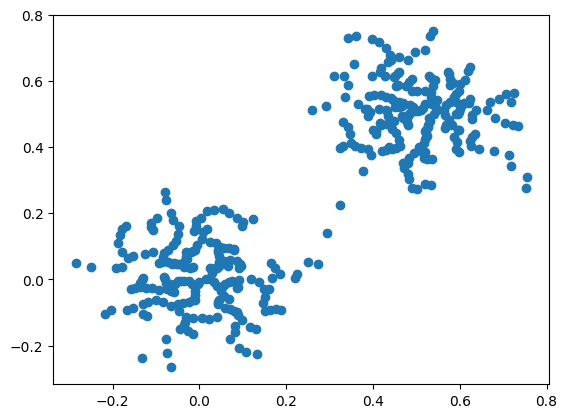

  8%|▊         | 49/600 [00:01<00:13, 40.47it/s]

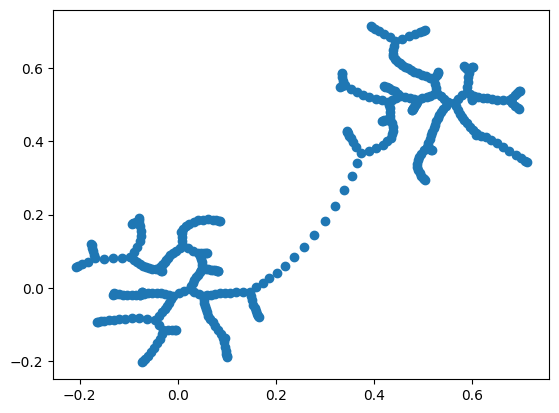

 16%|█▋        | 98/600 [00:02<00:12, 39.38it/s]

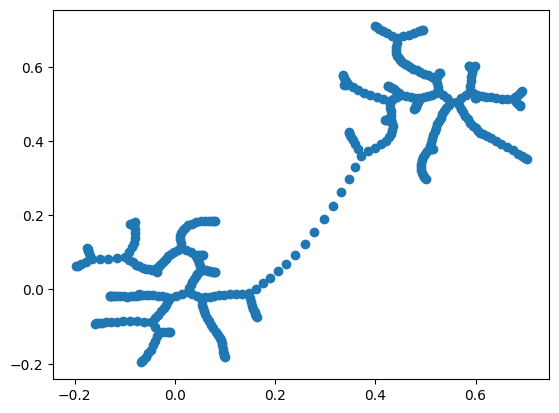

 25%|██▍       | 149/600 [00:04<00:11, 40.28it/s]

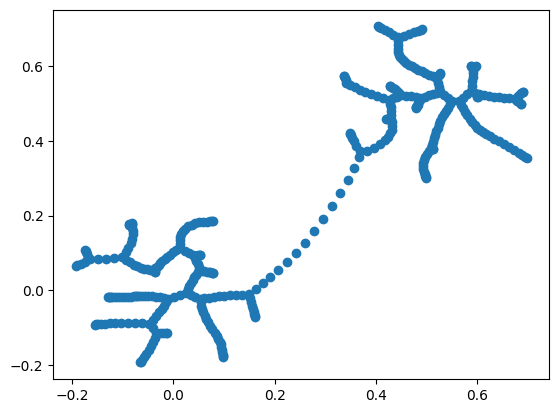

 33%|███▎      | 200/600 [00:05<00:09, 40.90it/s]

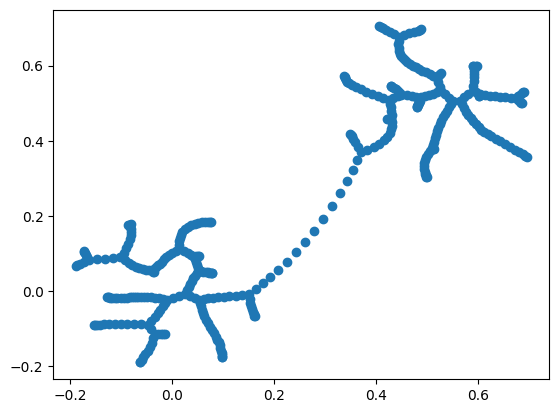

 41%|████▏     | 248/600 [00:07<00:08, 40.07it/s]

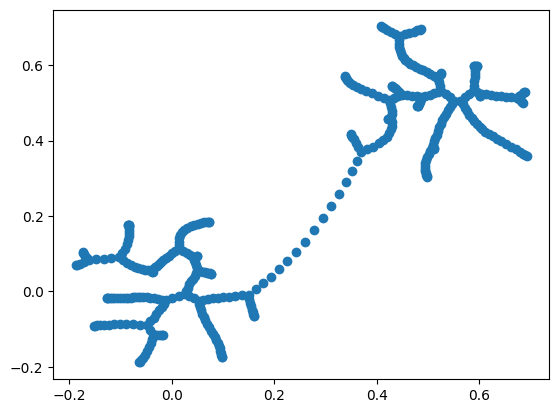

 50%|█████     | 300/600 [00:08<00:10, 29.84it/s]

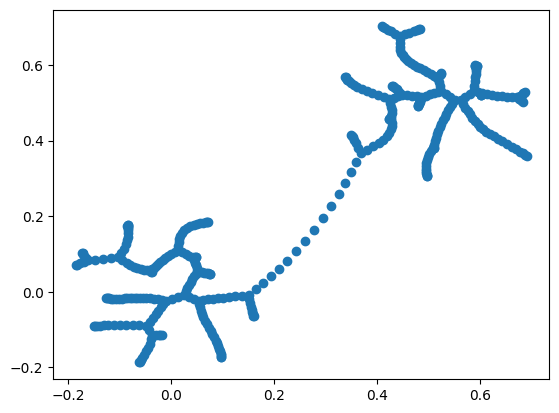

 58%|█████▊    | 349/600 [00:11<00:13, 17.95it/s]

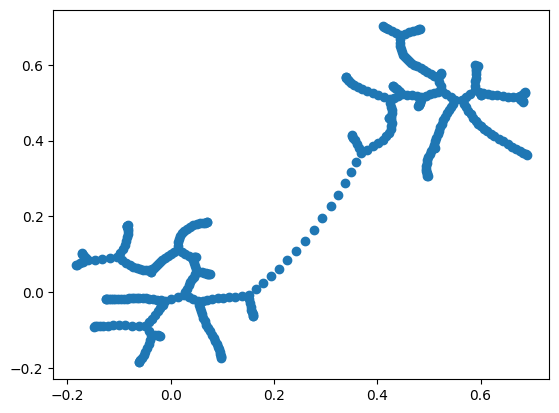

 66%|██████▋   | 399/600 [00:13<00:05, 38.78it/s]

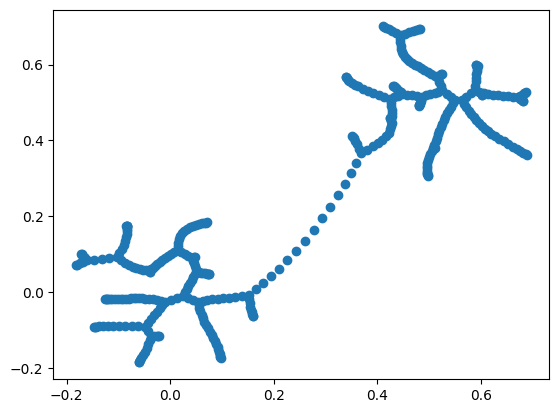

 74%|███████▍  | 446/600 [00:14<00:03, 41.09it/s]

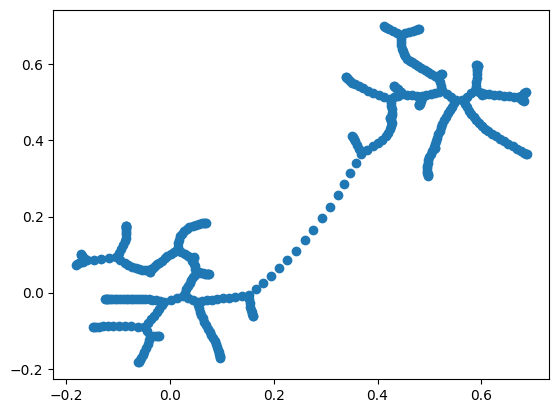

 83%|████████▎ | 496/600 [00:16<00:02, 40.44it/s]

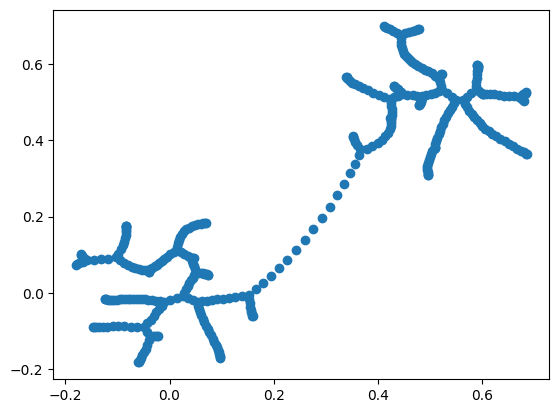

 92%|█████████▏| 550/600 [00:17<00:01, 40.75it/s]

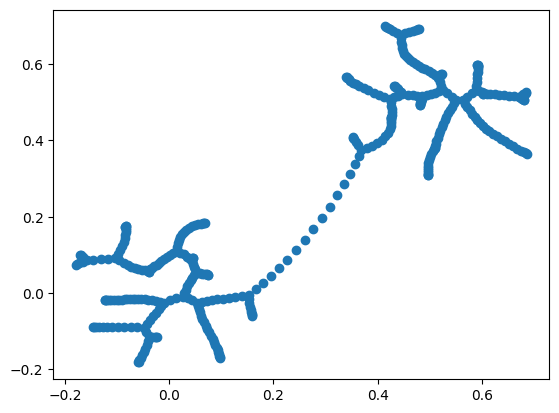

100%|██████████| 600/600 [00:19<00:00, 31.49it/s]


'\npts2 = (torch.rand((200, 2)) * 2 - 1).requires_grad_()\nopt = torch.optim.SGD([pts2], lr=1)\nscheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])\nfor idx in range(1):\n    opt.zero_grad()\n    myloss2(pts2,pts).backward()\n    opt.step()\n    scheduler.step()\n    # Draw every 100 epochs\n    if idx % 100 == 9:\n        P = pts2.detach().numpy()\n        plt.scatter(P[:, 0], P[:, 1])\n        plt.show()\n'

In [ ]:
pts = (torch.rand((100, 2)) * 2 - 1).requires_grad_()
points_near_1 = torch.randn((200, 2)) * 0.1 + 0.5

# 生成400个在 (0, 0, 0) 附近的点
points_near_0 = torch.randn((200, 2)) * 0.1

pts = torch.cat((points_near_1, points_near_0), dim=0).requires_grad_()
opt = torch.optim.SGD([pts], lr=0.2)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
from tqdm import tqdm
for idx in tqdm(range(600)):
    opt.zero_grad()
    topoloss_connectivity(pts,topk = 3).backward()
    opt.step()
    scheduler.step()
    # Draw every 100 epochs
    if idx % 50 == 0:
        P = pts.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()

'''
pts2 = (torch.rand((200, 2)) * 2 - 1).requires_grad_()
opt = torch.optim.SGD([pts2], lr=1)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
for idx in range(1):
    opt.zero_grad()
    myloss2(pts2,pts).backward()
    opt.step()
    scheduler.step()
    # Draw every 100 epochs
    if idx % 100 == 9:
        P = pts2.detach().numpy()
        plt.scatter(P[:, 0], P[:, 1])
        plt.show()
'''

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


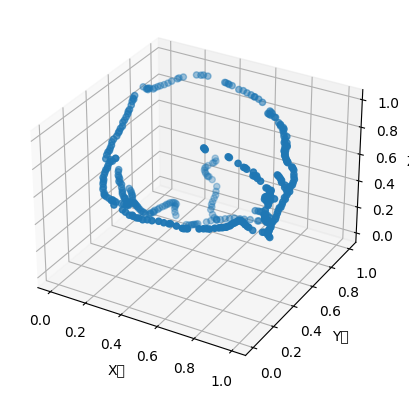

402


  0%|          | 0/600 [00:00<?, ?it/s]

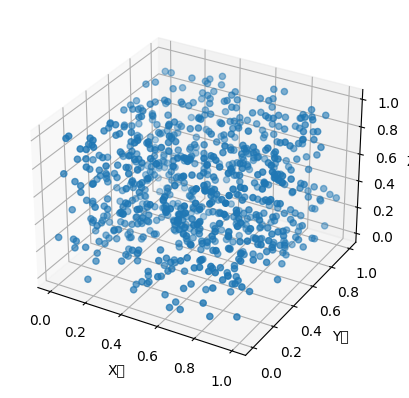

<ipython-input-31-21dbbd464ddc>:450: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.
 17%|█▋        | 100/600 [00:13<01:11,  6.98it/s]

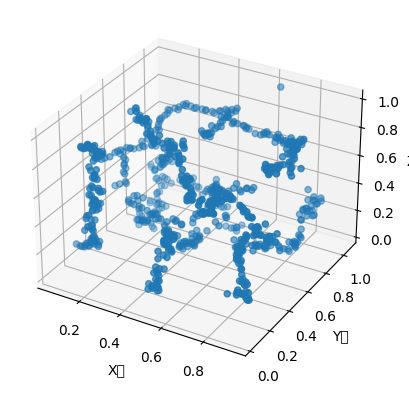

 33%|███▎      | 199/600 [00:24<00:39, 10.23it/s]

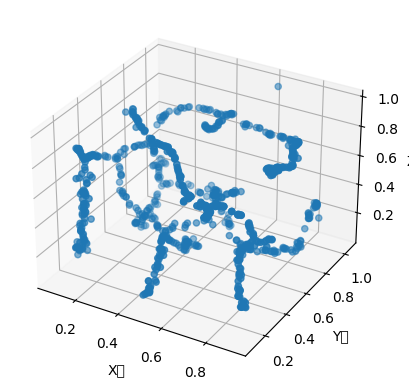

 50%|████▉     | 299/600 [00:36<00:29, 10.20it/s]

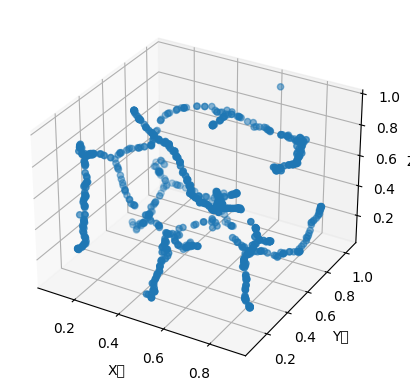

 67%|██████▋   | 400/600 [00:48<00:19, 10.17it/s]

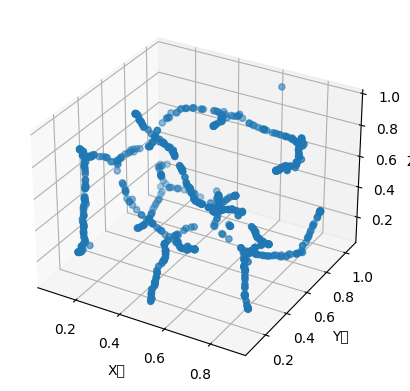

 83%|████████▎ | 500/600 [00:59<00:10,  9.12it/s]

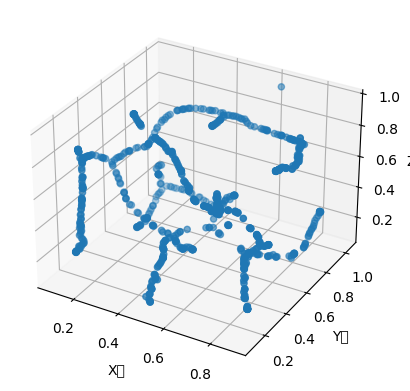

100%|██████████| 600/600 [01:11<00:00,  8.39it/s]


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from plyfile import PlyData, PlyElement
from sklearn import datasets


file_name = '/content/10016975.ply'
plydata = PlyData.read(file_name)
vertices = plydata['vertex']
pcd = vertices.data
points = []
flag = 0
i = 0
for pc in pcd:

  if (flag%4 == 0):
    points.append([pc[0],pc[1],pc[2]])
    flag+=1
  else:
    flag+=1
'''
for pc in pcd:
  if i <= 10000:
    i+=1
    continue
  if (flag%10 == 0):
    points.append([pc[0],pc[1],pc[2]])
    flag+=1
  else:
    flag+=1
'''
points = np.array(points)
x_min, x_max = points[:, 0].min(), points[:, 0].max()
y_min, y_max = points[:, 1].min(), points[:, 1].max()
z_min, z_max = points[:, 2].min(), points[:, 2].max()

# 归一化
points[:, 0] = (points[:, 0] - x_min) / (x_max - x_min)
points[:, 1] = (points[:, 1] - y_min) / (y_max - y_min)
points[:, 2] = (points[:, 2] - z_min) / (z_max - z_min)
pcd = points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 从坐标列表中提取x、y、z坐标
x = [coord[0] for coord in pcd]
y = [coord[1] for coord in pcd]
z = [coord[2] for coord in pcd]

# 绘制三维散点图
ax.scatter(x, y, z)

# 设置坐标轴标签
ax.set_xlabel('X轴')
ax.set_ylabel('Y轴')
ax.set_zlabel('Z轴')

# 显示图形
plt.show()
print(len(pcd))
pts = torch.tensor(pcd, dtype=torch.float32)



points_near_1 = torch.randn((200, 3)) * 0.1 + 0.5

# 生成400个在 (0, 0, 0) 附近的点
points_near_0 = torch.randn((200, 3)) * 0.1

pts2 = torch.cat((points_near_1, points_near_0), dim=0).requires_grad_()


pts2 = (torch.rand((800, 3))).requires_grad_()
opt = torch.optim.SGD([pts2], lr=0.2)
scheduler = LambdaLR(opt,[lambda epoch: 10./(10+epoch)])
from tqdm import tqdm

for idx in tqdm(range(600)):

    # Draw every 100 epochs
    if idx % 100 == 0:
        pcd = pts2.detach().numpy()
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # 从坐标列表中提取x、y、z坐标
        x = [coord[0] for coord in pcd]
        y = [coord[1] for coord in pcd]
        z = [coord[2] for coord in pcd]

        # 绘制三维散点图
        ax.scatter(x, y, z)

        # 设置坐标轴标签
        ax.set_xlabel('X轴')
        ax.set_ylabel('Y轴')
        ax.set_zlabel('Z轴')
        plt.show()
    opt.zero_grad()
    topoloss_wasserstein_based(pts2,pts).backward()
    opt.step()
    scheduler.step()